# Development and Nonlinear Analysis of the CRM-like Box Beam Model

In [1]:
# Import settings and constants
import os   # module for interfacing with the underlying operating system
import sys  # module for interacting with the Python interpreter
parent_directory = os.path.join(os.path.dirname(os.getcwd()))
sys.path.append(parent_directory)
from settings import *

# Define name of directory where to save analyses and figures
FIGURES_DIRECTORY_PATH = os.getcwd()
DATA_DIRECTORY_PATH = r"C:\Users\qa21944\Github\phd-jupyter-notebooks\notebooks\analyses\18_Development_and_Nonlinear_Structural_Stability_Analysis_of_a_CRM-like_Box_Beam_Model"

# Allow for interactive plots
%matplotlib widget

## Development of the Model

Define constants of the model.

In [2]:
import numpy as np  # module for numerical operations

L = 29.38e3  # [mm] box beam length
W = 3.41e3   # [mm] box beam width
H = 0.77e3   # [mm] box beam height
H_S = H/10   # [mm] stiffener height
no_stiffeners = 2  # number of stiffeners
stiffeners_x_locations = np.linspace(0, W, no_stiffeners + 2)[1:-1]  # [mm] stiffeners x-coordinates
stiffeners_spacing = W/(no_stiffeners + 1)  # [mm] stiffeners spacing
ribs_spacing = stiffeners_spacing*1.4 # [mm] ribs spacing
no_ribs = round(L/ribs_spacing) + 1  # number of ribs
ribs_y_locations = np.linspace(0, L, no_ribs)  # [mm] ribs y-coordinates


Plot mesh convergence study results.

Degrees of freedom:  [   24522    50442    85866   192354   359970   790674  1777794  3990282
  8902986 19803858]
Linear buckling loads:  [13358.9 12702.1 12516.5 12414.4 12403.8 12405.8 12401.4 12407.9 12407.6
 12418.3]
Percentage differences:  [ 7.6  2.3  0.8 -0.  -0.1 -0.1 -0.1 -0.1 -0.1  0. ]


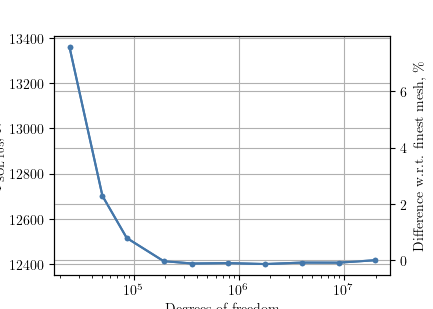

In [3]:
from pyNastran.op2.op2 import read_op2  # import function to read op2 file

# Import helper modules
main_directory = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(main_directory)
from resources import box_beam_utils

# Define shell elements' lengths to be used for the mesh convergence study and print them to screen
target_element_lengths = np.geomspace(H/2, H_S/8, 10) # [m]

# Initialize arrays with number of elements, number of degrees of freedom and linear buckling loads
dofs = np.empty(np.shape(target_element_lengths), dtype=int)
linear_buckling_loads = np.empty(np.shape(target_element_lengths))

# Iterate through the different target element lengths
for count, element_length in enumerate(target_element_lengths):
    # Generate mesh
    mesh = box_beam_utils.mesh_box_beam_reinforced_with_ribs_and_stiffeners(
        width=W, height=H, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
        stiffeners_height=H_S, element_length=element_length)
    nodes_connectivity_matrix = mesh.faces.reshape(-1, 5)[:, 1:]
    
    # Read op2 file
    input_name = f"sol_105_{len(nodes_connectivity_matrix)}_elements"
    op2_filepath = os.path.join(DATA_DIRECTORY_PATH, input_name + '.op2')
    sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
    
    # Find number of degrees of freedom and critical buckling load
    constrained_nodes_ids = next(iter(sol_105_op2.spcs.values()))[0].node_ids
    dofs[count] = (len(sol_105_op2.nodes) - len(constrained_nodes_ids))*6
    linear_buckling_loads[count] = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
    
# Plot buckling loads vs degrees of freedom with a log scale along the x-axis
fig, ax1 = plt.subplots(figsize=(TEXTWIDTH_INCHES*.7, TEXTWIDTH_INCHES*.5))  # create a figure and set of axes
buckling_load_line = ax1.semilogx(dofs, linear_buckling_loads, 'o-')

# Create a twin set of axes to plot percentage difference vs degrees of freedom
ax2 = ax1.twinx()
percentage_diff = (linear_buckling_loads/linear_buckling_loads[-1]-1)*100
percentage_diff_line = ax2.plot(dofs, percentage_diff, 'o-')

# Print degrees of freedom, linear buckling loads and percentage differences to screen
np.set_printoptions(precision=1, suppress=True)
print("Degrees of freedom: ", dofs)
print("Linear buckling loads: ", linear_buckling_loads)
print("Percentage differences: ", percentage_diff)

# Set axes labels and grid
ax1.set_xlabel("Degrees of freedom")
ax1.set_ylabel("$P_\mathrm{SOL\,105}$, N")
ax2.set_ylabel("Difference w.r.t. finest mesh, \%")
ax1.grid(True)
ax2.grid(True)

# Show plot and save figure
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "MeshConvergence.pdf"), bbox_inches='tight', pad_inches=0)

Plot critical buckling mode of converged mesh.

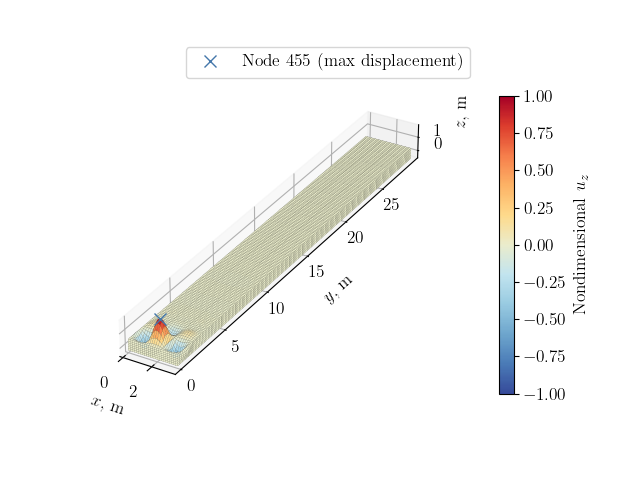

In [4]:
from resources import plot_utils

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=25)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 90  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .62))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-.07, .18))  # move colorbar upwards

# Plot buckling mode
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE/0.8,
                     'lines.markersize': 8})
input_name = f"sol_105_14976_elements"
op2_filepath = os.path.join(DATA_DIRECTORY_PATH, input_name + '.op2')
sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
amplification_factor = 1.5  # amplification factor for displacements
clim = [-1, 1]  # colorbar limits
fig, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component="tz", colormap="sunset", length_unit='m',
    displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3, clim=clim)

# Plot node where maximum displacement occurs
root_node_id = plot_utils.plot_max_displacement_node(
    axes=ax, op2=sol_105_op2, displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3)
ax.legend(bbox_to_anchor=(.93, .92))

# Adjust plot and show it
adjust_3d_plot(ax, cbar)
plt.show()

# Save figure
BBOX_COLORBAR = fig.bbox_inches.from_bounds(.8, .5, 5.2, 3.9)  # create bounding box for figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"InitialCriticalBucklingMode.pdf"), bbox_inches=BBOX_COLORBAR, pad_inches=0)

# Restore default sizes
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE,
                     'lines.markersize': DEFAULT_MARKER_SIZE})

Plot eigenvalue diagram.

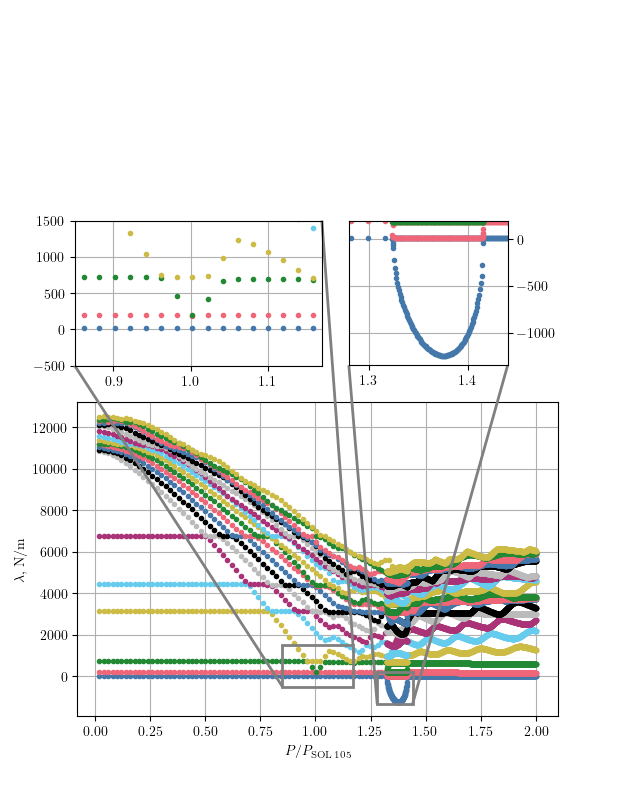

In [5]:
from resources import pynastran_utils
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes

# Read load histories
input_name = f"sol_106_14976_elements_epsu1e-4"
op2_filepath = os.path.join(DATA_DIRECTORY_PATH, input_name + '.op2')
sol_106_op2 = read_op2(op2_filepath, load_geometry=True, debug=None)
_, loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2=sol_106_op2)
DESIGN_LOAD = 12517.  # [N] design load
nondimensional_applied_loads = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD

# Read eigenvalues
f06_path = os.path.join(DATA_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Create the figure
fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCHES, TEXTWIDTH_INCHES*1.3))
fig.subplots_adjust(top=.5)

# Plot eigenvalues vs applied load
plt.plot(nondimensional_applied_loads, eigenvalues.T*1e3, "o")  # convert eigenvalues from N/mm to N/m
plt.ylabel("$\lambda,\,\mathrm{N/m}$")
plt.xlabel("$P/P_\mathrm{SOL\,105}$")
plt.grid(True)

# Create the first zoomed inset
x1, x2 = .85, 1.17  # region of interest for the first zoomed inset
axins1 = zoomed_inset_axes(ax, zoom=3.5, loc="upper left", bbox_to_anchor=(-.02, 1.6), bbox_transform=ax.transAxes)
axins1.plot(nondimensional_applied_loads, eigenvalues.T * 1e3, "o")
axins1.set_xlim(x1, x2)  # Adjust the limits as needed
axins1.set_ylim(-500, 1500)    # Adjust the limits as needed
axins1.set_xticks([0.9, 1.0, 1.1])
mark_inset(ax, axins1, loc1=3, loc2=1, fc="none", ec="0.5", linewidth=2, zorder=2)  # Connect to the region of interest

# Create the second zoomed inset
x1, x2 = 1.28, 1.44  # region of interest for the second zoomed inset
axins2 = zoomed_inset_axes(ax, zoom=4.5, loc="upper right", bbox_to_anchor=(.91, 1.6), bbox_transform=ax.transAxes)
axins2.plot(nondimensional_applied_loads, eigenvalues.T * 1e3, "o")
axins2.set_xlim(x1, x2)  # Adjust the limits based on your region of interest
axins2.set_ylim(-1350, 200)  # Adjust the limits as needed
# axins2.tick_params(labelleft=False, labelbottom=True)
axins2.yaxis.tick_right()
mark_inset(ax, axins2, loc1=3, loc2=4, fc="none", ec="0.5", linewidth=2, zorder=2)  # Connect to the region of interest

# Set the appearance of the insets
axins1.grid(True)
axins2.grid(True)

# Adjust layout for better appearance
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "TipLoadInitialEigenvalues.pdf"), bbox_inches='tight', pad_inches=0)

Plot load vs root displacement curve.

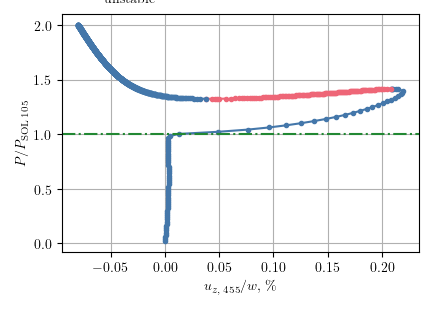

In [6]:
from resources import pynastran_utils

# Read displacement history
tip_node_xyz = np.array([W/2, L, 0])  # [mm] tip node coordinates
tip_node_id = np.argmin(np.linalg.norm(np.array([sol_106_op2.nodes[i].xyz for i in sol_106_op2.nodes]) - tip_node_xyz, axis=1)) + 1
plot_node_ids = [root_node_id, tip_node_id]  # node IDs to plot in the load-displacement diagrams
_, _, displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2=sol_106_op2, node_ids=plot_node_ids)

# Plot nondimensional applied load vs nondimensional root displacement
fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCHES*.7, TEXTWIDTH_INCHES*.5))  # create a figure and set of axes
plot_utils.plot_2d_load_displacements_stability(
            ax,
            displacements[root_node_id][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/W*100,
            nondimensional_applied_loads,
            eigenvalues,
            MARKERS[0], COLORS[0])

# Plot glass ceiling of linear buckling
ax.axhline(y=1., color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling

# Set up legend entries
stable_line = Line2D([0], [0], linestyle='-', marker=MARKERS[0], color=COLORS[0], label="stable")
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="glass ceiling of linear buckling")

# Finalize plot appearance
ax.set_xlabel(f"$u_{{z,\,{root_node_id:d}}}/w$, \%")
ax.set_ylabel("$P/P_\mathrm{SOL\,105}$")
ax.grid(visible=True)
plt.tight_layout()  # ensures proper spacing between subplots
fig.legend(handles=[stable_line, unstable_line, glass_ceiling_line], loc="upper center", bbox_to_anchor=(0.54, 1.12), ncol=2, frameon=False)

# Show plot and save figure
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "TipLoadInitialRootDisplacement.pdf"), bbox_inches='tight', pad_inches=0)


Plot deformation before and after snap.

Deformation before snap:


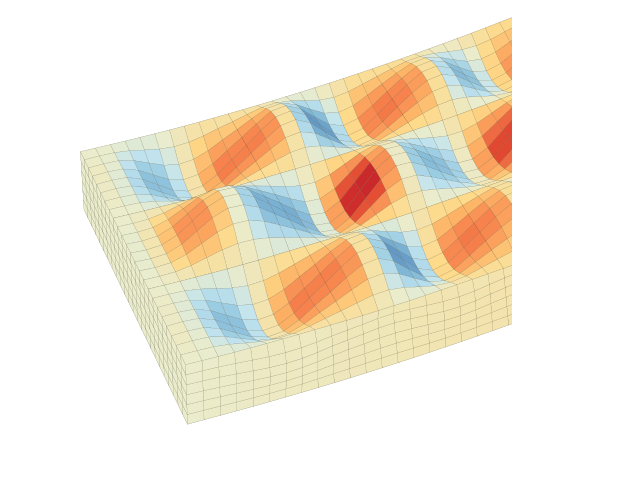

Deformation after snap


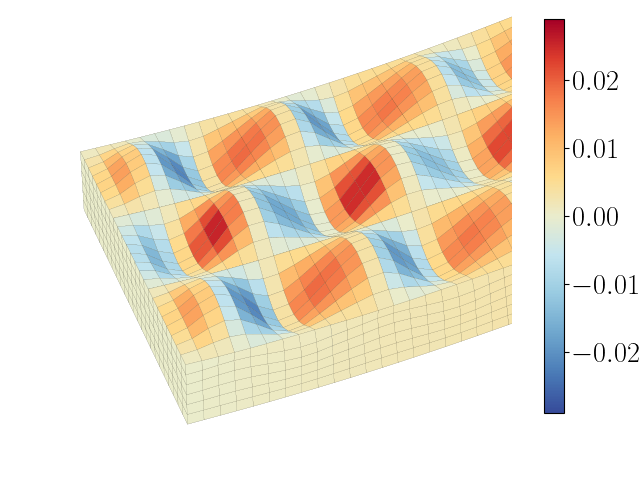

In [7]:
# Increase font size because figures are rendered side by side in the paper
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/.49)})

# Define function to zoom deformation plot to root
def zoom_to_root(axes):
    axes.set_xlim(0, W*1e-3)
    axes.set_ylim(0, 4*H*1e-3)
    axes.set_zlim(-H/2*1e-3, H*1e-3)
    axes.set_box_aspect([ub - lb for lb, ub in (getattr(axes, f"get_{a}lim")() for a in 'xyz')])
    plt.axis('off')
    axes.view_init(40, -20)

# Find index of limit point load
limit_point_load_index = np.where(eigenvalues[0, :] < 0)[0][0] - 1  # index of first negative eigenvalue minus one

# Plot deformation just before limit point
print("Deformation before snap:")
amplification_factor = 50
clim = [-.029, .029]  # color limits for deformation plot
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2, subcase_id=FIRST_SUBCASE_ID, load_step=limit_point_load_index + 1, displacement_component='rx',
    colormap='sunset', length_unit='m', unit_scale_factor=1e-3, displacement_amplification_factor=amplification_factor, clim=clim)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax)
cbar.remove()
zoom_to_root(ax)
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "TipLoadDeformationBeforeSnap.pdf"), bbox_inches='tight', pad_inches=0)

# Plot deformation just after snap
skip = 10  # number of increments to skip for selection of applied load after snap
subsequent_values = nondimensional_applied_loads[limit_point_load_index + skip:]  # consider only applied loads after snap
closest_index_in_subsequent = np.argmin(np.abs(nondimensional_applied_loads[limit_point_load_index] - subsequent_values))  # find index of closest value to applied load at first limit point
closest_index = limit_point_load_index + skip + closest_index_in_subsequent  # sum found index to index of first negative eigenvalue
print("Deformation after snap")
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2, subcase_id=FIRST_SUBCASE_ID, load_step=closest_index + 1, displacement_component='rx',
    colormap='sunset', length_unit='m', unit_scale_factor=1e-3, displacement_amplification_factor=amplification_factor, clim=clim)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax)
cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, .82))  # decrease colorbar size
cbar.ax.set_position(cbar.ax.get_position().translated(0, .14))  # move colorbar upwards
zoom_to_root(ax)
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "TipLoadDeformationAfterSnap.pdf"), bbox_inches='tight', pad_inches=0)

# Restore default sizes
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

Plot load vs tip displacement curve.

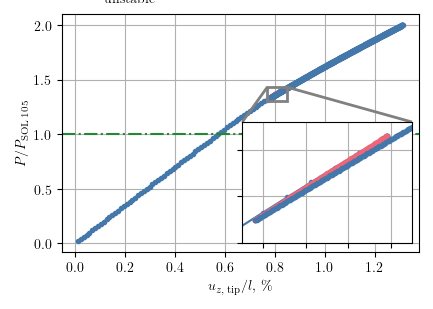

In [8]:
# Plot nondimensional applied load vs nondimensional root displacement
fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCHES*.7, TEXTWIDTH_INCHES*.5))  # create a figure and set of axes
plot_utils.plot_2d_load_displacements_stability(
            ax,
            displacements[tip_node_id][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L*100,
            nondimensional_applied_loads,
            eigenvalues,
            MARKERS[0], COLORS[0])

# Plot glass ceiling of linear buckling
ax.axhline(y=1., color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling

# Set up legend entries
stable_line = Line2D([0], [0], linestyle='-', marker=MARKERS[0], color=COLORS[0], label="stable")
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="glass ceiling of linear buckling")

# Finalize plot appearance
ax.set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
ax.set_ylabel("$P/P_\mathrm{SOL\,105}$")
ax.grid(visible=True)
plt.tight_layout()  # ensures proper spacing between subplots
fig.legend(handles=[stable_line, unstable_line, glass_ceiling_line], loc="upper center", bbox_to_anchor=(0.54, 1.12), ncol=2, frameon=False)

# Create zoomed inset to show unstable part of the curve
x1, x2 = .77, .85  # x-range of interest for the first zoomed inset
y1, y2 = 1.3, 1.43  # y-range of interest for the first zoomed inset
axins = zoomed_inset_axes(ax, zoom=8.5, loc="lower right", bbox_to_anchor=(1., .01), bbox_transform=ax.transAxes)
plot_utils.plot_2d_load_displacements_stability(
            axins,
            displacements[tip_node_id][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L*100,
            nondimensional_applied_loads,
            eigenvalues,
            MARKERS[0], COLORS[0])
axins.set_xlim(x1, x2)  # Adjust the limits as needed
axins.set_ylim(y1, y2)    # Adjust the limits as needed
axins.tick_params(labelleft=False, labelbottom=False)
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5", linewidth=2, zorder=2)  # Connect to the region of interest
axins.grid(True)

# Show plot and save figure
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "TipLoadInitialTipDisplacement.pdf"), bbox_inches='tight', pad_inches=0)

Plot mesh convergence verification.

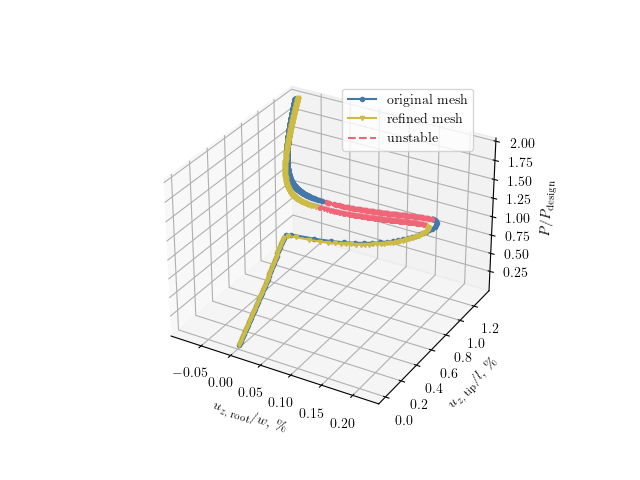

In [9]:
# Define dictionary with names of input files
sol_105_input_names = ["sol_105_14976_elements.op2", "sol_105_48300_elements.op2"]
sol_106_input_name_dict = {"original mesh": "14976_elements_epsu1e-4",
                           "refined mesh": "48300_elements"}

# Initialize dictionaries to store ids of nodes where max displacement occurs and tip nodes
root_node_id_dict = {}  # dictionary to store ids of nodes where max displacement occurs
tip_node_id_dict = {}  # dictionary to store ids of tip nodes

# Initialize dictionaries to store eigenvalues and nondimensional loads and displacements
eigenvalues_dict = {}  # dictionary to store eigenvalues
nondimensional_loads_dict = {}  # dictionary to store nondimensional loads
nondimensional_displacements_dict = {}  # dictionary to store nondimensional displacements

# Create 3D plot of equilibrium diagram
fig = plt.figure()  # create a figure
ax_3d = plt.axes(projection="3d")  # create 3D axes
stable_lines = []  # list to store proxy artists for the legend

# Iterate over the different meshes
for count, key in enumerate(sol_106_input_name_dict):
    # Read op2 file of linear buckling analysis
    op2_filepath = os.path.join(DATA_DIRECTORY_PATH, sol_105_input_names[count])
    sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

    # Find node where max displacement occurs
    max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
    root_node_id_dict[key] = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]  # find id of node with max displacement magnitude
    
    # Find tip node id
    nodes_xyz_array = np.array([node.xyz for node in sol_105_op2.nodes.values()])  # get nodes' coordinates
    tip_node_id_dict[key] = np.argmin(np.linalg.norm(nodes_xyz_array - tip_node_xyz, axis=1)) + 1  # find id of tip node

    # Read op2 file of nonlinear analysis
    op2_filepath = os.path.join(DATA_DIRECTORY_PATH, f"sol_106_{sol_106_input_name_dict[key]}.op2")
    sol_106_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
    
    # Read load-displacement history
    _, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_op2, node_ids=[root_node_id_dict[key], tip_node_id_dict[key]])
    
    # Read eigenvalues
    f06_filepath = os.path.join(DATA_DIRECTORY_PATH, f"sol_106_{sol_106_input_name_dict[key]}.f06")  # path of f06 file
    eigenvalues_dict[key] = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)  # read eigenvalues from f06 file

    # Nondimensionalize loads and displacements
    nondimensional_loads_dict[key] = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD
    nondimensional_displacements_dict[key] = {"root": displacements[root_node_id_dict[key]][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/W,
                                    "tip": displacements[tip_node_id_dict[key]][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L}

    # Plot load-displacement curve
    plot_utils.plot_3d_load_displacements_stability(axes=ax_3d,
                                                    displacements1=nondimensional_displacements_dict[key]["root"]*100,
                                                    displacements2=nondimensional_displacements_dict[key]["tip"]*100,
                                                    loads=nondimensional_loads_dict[key],
                                                    eigenvalues=eigenvalues_dict[key],
                                                    marker=MARKERS[count], color=COLORS[count])
    stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[count], color=COLORS[count], label=key))  # create proxy artist for the legend

# Add proxy artist for unstable lines and create legend
fig.legend(handles=stable_lines + [unstable_line], bbox_to_anchor=(0.75, 0.83))

# Set axes labels and grid
ax_3d.set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
ax_3d.set_ylabel("$u_{z,\,\mathrm{tip}}/l$, \%")
ax_3d.set_zlabel("$P/P_\mathrm{design}$")
ax_3d.grid(visible=True)

# Show plot and save figure
plt.show()
bounding_box = fig.bbox_inches.from_bounds(1.4, .4, 4.3, 3.7)  # create bounding box for figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "MeshConvergenceVerification.pdf"), bbox_inches=bounding_box, pad_inches=0)

Plot nonlinear analysis with coarse arc-length increments.

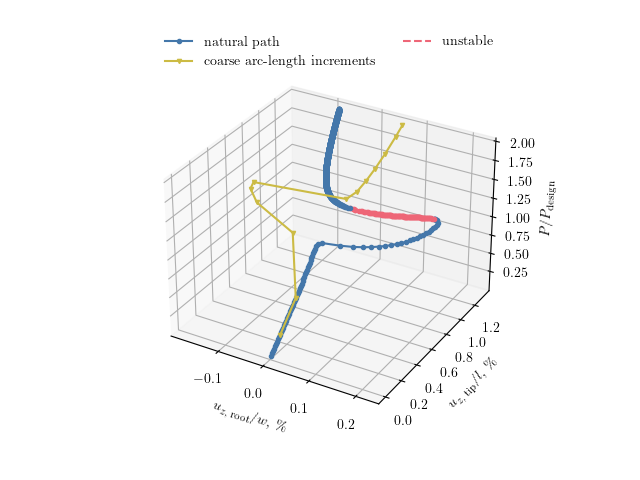

In [10]:
def plot_reference_natural_equilibrium_path(ax_3d):
    key = "original mesh"  # key of reference equilibrium path
    plot_utils.plot_3d_load_displacements_stability(axes=ax_3d,
                                                    displacements1=nondimensional_displacements_dict[key]["root"]*100,
                                                    displacements2=nondimensional_displacements_dict[key]["tip"]*100,
                                                    loads=nondimensional_loads_dict[key],
                                                    eigenvalues=eigenvalues_dict[key],
                                                    marker=MARKERS[0], color=COLORS[0])

# Create 3D plot of equilibrium diagram
fig = plt.figure()  # create a figure
ax_3d = plt.axes(projection="3d")  # create 3D axes
stable_lines = []  # list to store proxy artists for the legend

# Plot reference natural equilibrium path
plot_reference_natural_equilibrium_path(ax_3d)
stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[0], color=COLORS[0], label="natural path"))  # create proxy artist for the legend

# Plot equilibrium path for nonlinear analysis with coarse arc-length increments
# Read op2 file of nonlinear analysis
input_name = "sol_106_desiter5_equilibrium_path_verification"
op2_filepath = os.path.join(DATA_DIRECTORY_PATH, input_name + '.op2')
sol_106_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
    
# Read load-displacement history
key = "original mesh"  # key of reference equilibrium path
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2=sol_106_op2, node_ids=[root_node_id_dict[key], tip_node_id_dict[key]])
    
# Read eigenvalues
f06_filepath = os.path.join(DATA_DIRECTORY_PATH, input_name + '.f06')  # path of f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)  # read eigenvalues from f06 file

# Nondimensionalize loads and displacements of first subcase
nondimensional_loads = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD
nondimensional_displacements = {"root": displacements[root_node_id_dict[key]][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/W,
                                "tip": displacements[tip_node_id_dict[key]][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L}

# Plot load-displacement curve
no_first_subcase_increments = len(nondimensional_loads)
plot_utils.plot_3d_load_displacements_stability(axes=ax_3d,
                                                displacements1=nondimensional_displacements["root"]*100,
                                                displacements2=nondimensional_displacements["tip"]*100,
                                                loads=nondimensional_loads,
                                                eigenvalues=eigenvalues[:, :no_first_subcase_increments],
                                                marker=MARKERS[1], color=COLORS[1])
stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[1], color=COLORS[1], label="coarse arc-length increments"))  # create proxy artist for the legend

# Add proxy artist for unstable lines and create legend
fig.legend(handles=stable_lines + [unstable_line], bbox_to_anchor=(.79, 0.95), ncol=2, frameon=False)

# Set axes labels and grid
ax_3d.set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
ax_3d.set_ylabel("$u_{z,\,\mathrm{tip}}/l$, \%")
ax_3d.set_zlabel("$P/P_\mathrm{design}$")
ax_3d.grid(visible=True)

# Show plot and save figure
plt.show()
bounding_box = fig.bbox_inches.from_bounds(1.4, .4, 4.3, 4.1)  # create bounding box for figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "CoarseArcLengthIncrements.pdf"), bbox_inches=bounding_box, pad_inches=0)

Plot nonlinear analysis unloading the structure from the coarse arc-length result.

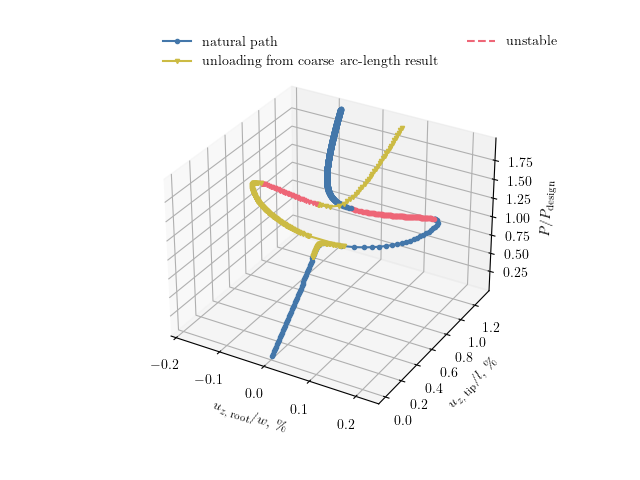

In [11]:
# Create 3D plot of equilibrium diagram
fig = plt.figure()  # create a figure
ax_3d = plt.axes(projection="3d")  # create 3D axes
stable_lines = []  # list to store proxy artists for the legend

# Plot reference natural equilibrium path
plot_reference_natural_equilibrium_path(ax_3d)
stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[0], color=COLORS[0], label="natural path"))  # create proxy artist for the legend

# Plot equilibrium path for nonlinear analysis with coarse arc-length increments
# Nondimensionalize loads and displacements of second subcase
nondimensional_loads = loads[SECOND_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD
nondimensional_displacements = {"root": displacements[root_node_id_dict[key]][SECOND_SUBCASE_ID][:, Z_COMPONENT_INDEX]/W,
                                "tip": displacements[tip_node_id_dict[key]][SECOND_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L}

# Plot load-displacement curve
plot_utils.plot_3d_load_displacements_stability(axes=ax_3d,
                                                displacements1=nondimensional_displacements["root"]*100,
                                                displacements2=nondimensional_displacements["tip"]*100,
                                                loads=nondimensional_loads,
                                                eigenvalues=eigenvalues[:, no_first_subcase_increments:],
                                                marker=MARKERS[1], color=COLORS[1])
stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[1], color=COLORS[1], label="unloading from coarse arc-length result"))  # create proxy artist for the legend

# Add proxy artist for unstable lines and create legend
fig.legend(handles=stable_lines + [unstable_line], bbox_to_anchor=(.89, 0.95), ncol=2, frameon=False)

# Set axes labels and grid
ax_3d.set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
ax_3d.set_ylabel("$u_{z,\,\mathrm{tip}}/l$, \%")
ax_3d.set_zlabel("$P/P_\mathrm{design}$")
ax_3d.grid(visible=True)

# Show plot and save figure
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "UnloadingFromCoarseArcLengthResult.pdf"), bbox_inches=bounding_box, pad_inches=0)

Plot nonlinear analysis unloading the structure with MAXITER=3.

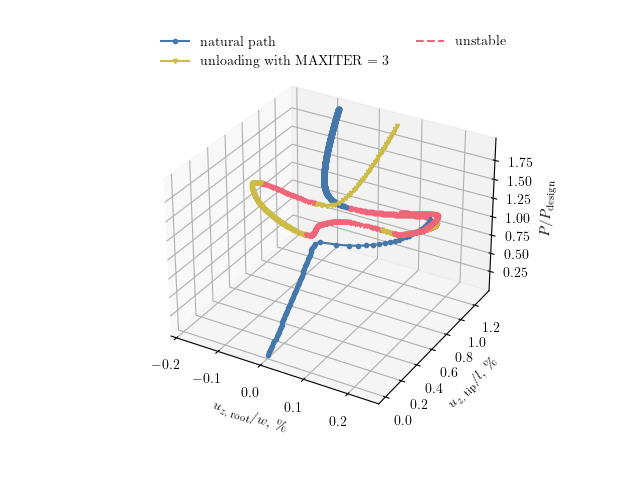

In [12]:
# Create 3D plot of equilibrium diagram
fig = plt.figure()  # create a figure
ax_3d = plt.axes(projection="3d")  # create 3D axes
stable_lines = []  # list to store proxy artists for the legend

# Plot reference natural equilibrium path
plot_reference_natural_equilibrium_path(ax_3d)
stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[0], color=COLORS[0], label="natural path"))  # create proxy artist for the legend

# Plot equilibrium path for nonlinear analysis with coarse arc-length increments
# Read op2 file of nonlinear analysis
input_name = "sol_106_desiter5_equilibrium_path_verification_maxiter3"
op2_filepath = os.path.join(DATA_DIRECTORY_PATH, input_name + '.op2')
sol_106_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
    
# Read load-displacement history
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2=sol_106_op2, node_ids=[root_node_id_dict[key], tip_node_id_dict[key]])
    
# Read eigenvalues
f06_filepath = os.path.join(DATA_DIRECTORY_PATH, input_name + '.f06')  # path of f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)  # read eigenvalues from f06 file

# Nondimensionalize loads and displacements of first subcase
nondimensional_loads = loads[SECOND_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD
nondimensional_displacements = {"root": displacements[root_node_id_dict[key]][SECOND_SUBCASE_ID][:, Z_COMPONENT_INDEX]/W,
                                "tip": displacements[tip_node_id_dict[key]][SECOND_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L}

# Plot load-displacement curve
no_first_subcase_increments = loads[FIRST_SUBCASE_ID].shape[0]
plot_utils.plot_3d_load_displacements_stability(axes=ax_3d,
                                                displacements1=nondimensional_displacements["root"]*100,
                                                displacements2=nondimensional_displacements["tip"]*100,
                                                loads=nondimensional_loads,
                                                eigenvalues=eigenvalues[:, no_first_subcase_increments:],
                                                marker=MARKERS[1], color=COLORS[1])
stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[1], color=COLORS[1], label="unloading with $\mathrm{MAXITER}=3$"))  # create proxy artist for the legend

# Add proxy artist for unstable lines and create legend
fig.legend(handles=stable_lines + [unstable_line], bbox_to_anchor=(.81, 0.95), ncol=2, frameon=False)

# Set axes labels and grid
ax_3d.set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
ax_3d.set_ylabel("$u_{z,\,\mathrm{tip}}/l$, \%")
ax_3d.set_zlabel("$P/P_\mathrm{design}$")
ax_3d.grid(visible=True)

# Show plot and save figure
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "UnloadingMaxiter3.pdf"), bbox_inches=bounding_box, pad_inches=0)